**Ejercicio 1:** Implemente las estructuras de datos y algoritmos básicos para la solución de un problema mediante algoritmos genéticos. Pruebe estas rutinas y compare los resultados con un método de gradiente descendiente para buscar el mínimo global de distintas funciones.

#### **Librerías**

In [35]:
from matplotlib import pyplot as plt
import numpy as np
import sympy as sp
import random

<h4><b>Algoritmo</b></h2>


En un principio, ya que vamos a trabajar tanto con números binarios como decimales vamos a necesitar una función que se encargue de la decodificación.
Como regla general, vamos a tomar el primer bit de la cadena como el bit de signo y los 4 últimos bits de la cadena como decimales. Los bits en el medio serán los bits de enteros y serán variables según el problema.

In [36]:
def decodif(poblacion):     # Pasa la población del genotipo (binario) al fenotipo (decimal)
    poblacion_dec = []
    for genotipo in poblacion:
        decimal = int(genotipo[1:-4], 2) + 0.1*int(genotipo[-4:],2)   # Convierte la cadena binaria a un entero
        if genotipo[0] == '1':
            poblacion_dec.append(-decimal)
        else:
            poblacion_dec.append(decimal)
    return poblacion_dec

Recordamos el diagrama de flujo de nuestro algoritmo:
<br><br>
<img src="data/diagflujo.png" width="200">

En particular, para los operadores de selección vamos a utilizar competencias para seleccionar nuestros individuos ganadores: elijo k individuos al azar, los hago copmetir y el mayor gana. Con varias etapas, simulamos un torneo entre los individuos de la población.

In [37]:
def competencias(aptitudes,k=2):
    competidores = np.random.randint(0,len(aptitudes),(2,1))
    ganador = np.argmax(aptitudes[competidores])
    return ganador

Luego tenemos los operadores de variación: la mutación y la cruza. Para esto generamos funciones auxiliares de la misma manera.

In [38]:
def cruza(padre,madre,prob):
    prob_i = np.random.rand()
    if prob_i < prob:
        punto_corte = random.randint(1,4)
        hijo1 = padre[:punto_corte] + madre[punto_corte:]
        hijo2 = madre[:punto_corte] + padre[punto_corte:]
    else:
        hijo1 = padre
        hijo2 = madre
    return hijo1,hijo2

def mutacion(individuo,prob):   # Le paso probabilidad a nivel de individuo
    prob_i = np.random.rand()
    if prob_i < prob:
        pos = np.random.choice(len(individuo))
        individuo_aux = list(individuo)
        if(individuo_aux[pos] == '0'):
            individuo_aux[pos] = '1'
        else:
            individuo_aux[pos] = '0'

        individuo = ''.join(individuo_aux) 
    return individuo

Definimos un operador de reemplazo para el algoritmo. En particular, vamos a utilizar el elitismo: los dos individuos más aptos pasan a la nueva generación sin ser cruzados o mutados.

In [39]:
def elitismo(poblacion,aptitudes):
    apt_aux = list(enumerate(aptitudes))
    ordenados = sorted(apt_aux,key=lambda x: x[1], reverse=True)
    idx1 = ordenados[0][0]  # Mayor aptitud
    idx2 = ordenados[1][0]  # Segunda mayor aptitud
    return idx1,idx2  # Devuelve los índices de los individuos 

La función general *algoritmo_genetico* va a recibir varios argumentos:
- **size_p:** Tamaño de la población o cantidad de individuos.
- **bits:** Longitud del cromosoma o número de bits para cada individuo de la población.
- **max_gen:** Número máximo de generaciones.
- **max_estable:** Cantidad de iteraciones para considerar una solución estable con elitismo.
- **func_aptitud:** Función para calcular aptitud de la población.
- **prob_mutacion:** Probabilidad asociada a la mutación.
- **prob_cruza:** Probabilidad asociada a la cruza.

In [40]:
def algoritmo_genetico(size_p,bits,max_gen,max_estable,func_aptitud,prob_mutacion,prob_cruza):

    # PASO 1: Inicialización de la población
    poblacion = [''.join(random.choices('01',k=(bits-1))) for _ in range(2*size_p)] # Inicializo con el doble de bits
    for individuo in poblacion:
        if int(individuo[-4],2) > 9:
            individuo = individuo[:-4] + '1001'     # Que no pase de 9 la parte decimal
        if int(individuo[:-4],2) > 99:
            individuo = '1100011' + individuo[-4:]  # Que no pase los 99 la parte entera
    
    # Divido la población para los x y los y:
    poblacion_x = poblacion[:len(poblacion)//2]
    poblacion_y = poblacion[len(poblacion)//2:]

    cont_estabilidad = 0;
    apt_max = 1e-6;

    for gen in range(max_gen):
        poblacion_dec_x = decodif(poblacion_x)                      # Decodifico para pasarselo a la función de aptitud
        poblacion_dec_y = decodif(poblacion_y)
        aptitudes = func_aptitud(poblacion_dec_x,poblacion_dec_y)   # Obtengo aptitudes
        nueva_pob_x = []
        nueva_pob_y = []

        # Elitismo
        idx1,idx2 = elitismo(poblacion,aptitudes)
        nueva_pob_x.append(poblacion_x[idx1])   # Mejor
        nueva_pob_y.append(poblacion_y[idx1])
        nueva_pob_x.append(poblacion_x[idx2])   # Segundo mejor
        nueva_pob_y.append(poblacion_y[idx2])  
        
        while(len(nueva_pob_x) < len(poblacion_x) and len(nueva_pob_y) < len(poblacion_y)):
            # PASO 2: Selección (elegimos uno de los métodos propuestos en funciones auxiliares):
            idx_padre = competencias(aptitudes,4)
            idx_madre = competencias(aptitudes,4)
            padre_x = poblacion_x[idx_padre]
            padre_y = poblacion_y[idx_padre]
            madre_x = poblacion_x[idx_madre]
            madre_y = poblacion_y[idx_madre]
            # PASO 3: CRUZA (me va a devolver los hijos cruzados o los padres, depende probabilidad)
            hijo1_x, hijo2_x = cruza(padre_x,madre_x,prob_cruza)  
            hijo1_y, hijo2_y = cruza(padre_y,madre_y,prob_cruza)             
            # PASO 4: MUTACION (me va a devolver hijos mutados o no, depende probabilidad)  
            hijo1_x = mutacion(hijo1_x,prob_mutacion)   
            hijo2_x = mutacion(hijo2_x,prob_mutacion)
            hijo1_y = mutacion(hijo1_y,prob_mutacion)   
            hijo2_y = mutacion(hijo2_y,prob_mutacion)
            # Los agrego a la nueva generación      
            nueva_pob_x.append(hijo1_x)
            nueva_pob_y.append(hijo2_x)
            nueva_pob_x.append(hijo1_y)
            nueva_pob_y.append(hijo2_y)

        # PASO 5: EVALUACIÓN (vemos si se estabilizó por elitismo)
        if(np.isclose(max(aptitudes),apt_max)):
            cont_estabilidad += 1
        else:
            cont_estabilidad = 0
        if(cont_estabilidad >= max_estable):
            break

        poblacion_x = nueva_pob_x
        poblacion_y = nueva_pob_y
        apt_max = max(aptitudes)

    poblacion_x_dec = decodif(poblacion_x)
    poblacion_y_dec = decodif(poblacion_y)
    apt_aux = list(enumerate(aptitudes))
    ordenados = sorted(apt_aux,key=lambda x: x[1], reverse=True)
    idx = ordenados[0][0]
    return poblacion_x[idx], poblacion_y[idx]

#### **Prueba**
Con el método del gradiente, realizamos una comparación entre los resultados que éste y nuestro algoritmo genético arrojan para las funciones propuestas. Como buscamos el mínimo de las funciones, queremos minimizar la función de aptitud y para eso multiplicamos nuestra función objetivo por -1.

**Función 2:** $ f(x, y) = (x^2 + y^2)^{0.25} [\sin^2 (50 (x^2 + y^2)^{0.1}) + 1]$, con $x, y \in [-100...100]$

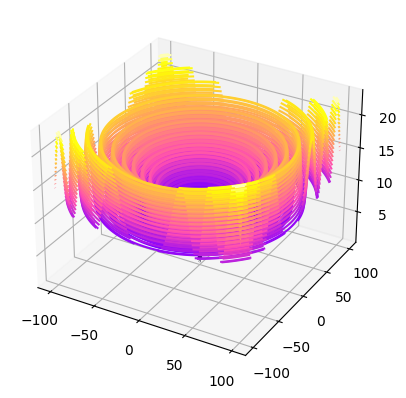

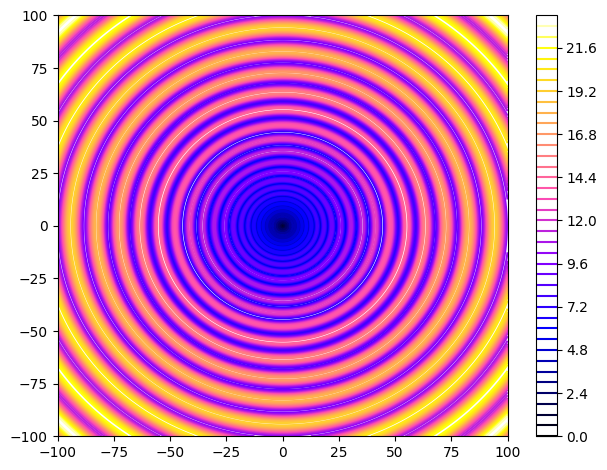

El mínimo de la función está en (0.10010010010010717,0.10010010010010717,0.5467853625415365)


In [41]:
def f2(x,y):
    return ((x**2 + y**2)**0.25)*((np.sin(50*(x**2 + y**2)**0.1))**2  + 1)

x = np.linspace(-100, 100, 1000)
y = np.linspace(-100, 100, 1000)

X, Y = np.meshgrid(x, y)
Z = f2(X, Y)

fig = plt.figure()
ax3d = fig.add_subplot(projection='3d')
ax3d.contour3D(X, Y, Z, 40,cmap='gnuplot2')
plt.show()
fig = plt.figure()
contour = plt.contour(X,Y,Z,40,cmap='gnuplot2')
plt.colorbar(contour)

plt.tight_layout()
plt.show()

print(f'El mínimo de la función está en ({x[np.argmin(f2(x,y))]},{y[np.argmin(f2(x,y))]},{np.min(f2(x,y))})')

- Mínimo mediante el algoritmo genético: Usamos 1 bit de signo, 9 bits para la parte entera del número (ya que 2^7 = 128) y 4 bits para la parte decimal. Luego, seteamos bits = 1 + 7 + 4 = 12

In [42]:
def func_aptitud(pob_x,pob_y):
    pob_x = np.array(pob_x)
    pob_y = np.array(pob_y)
    return -(((pob_x**2 + pob_y**2)**0.25)*((np.sin(50*(pob_x**2 + pob_y**2)**0.1))**2 + 1))    # -f1 para obtener la aptitud mínima en vez de máxima

size_p = 50
bits = 12
max_gen = 10000
max_estable = 100
prob_mutacion = 0.1
prob_cruza = 0.7
ganador_x,ganador_y = algoritmo_genetico(size_p,bits,max_gen,max_estable,func_aptitud,prob_mutacion,prob_cruza)

ganador_dec = decodif([ganador_x, ganador_y])
print('Mínimo encontrado en (',ganador_dec[0],',',ganador_dec[1],',',f2(ganador_dec[0],ganador_dec[1]),')')

Mínimo encontrado en ( 0.0 , 0.0 , 0.0 )


- Mínimo mediante método de gradiente descendiente:

In [43]:
def grad_f2_x(x,y):
    return ((0.5*x*((np.sin(50*(x**2 + y**2)**0.1))**2 + 1))/((x**2+y**2)**0.75) + (20*x*np.cos(50*(x**2 + y**2)**0.1)*np.sin(50*(x**2+y**2)**0.1))/((x**2+y**2)**0.65))
def grad_f2_y(x,y):
    return ((0.5*y*((np.sin(50*(x**2 + y**2)**0.1))**2 + 1))/((x**2+y**2)**0.75) + (20*y*np.cos(50*(x**2 + y**2)**0.1)*np.sin(50*(x**2+y**2)**0.1))/((x**2+y**2)**0.65))

lr = 0.01
it = 200
x = np.random.randint(-100,100)
y = np.random.randint(-100,100)
for i in range(it):
        x -= lr*grad_f2_x(x, y)
        y -= lr*grad_f2_y(x, y)

minimo = f2(x,y)
print('Mínimo encontrado en (',x,',',y,' ',minimo,')')

Mínimo encontrado en ( -75.36374294714403 , -18.601309795051325   8.811454149509144 )
